In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import copy
import glob

from tqdm.auto import trange

import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import Tensor
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset
import torch.optim as optim

from torchvision import datasets, transforms


import matplotlib.pyplot as plt

# from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap

import seaborn as sns

from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import adjusted_rand_score, accuracy_score, davies_bouldin_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

# Used to save data into files
import pickle as pkl
import os

# Used to measure time
import time

/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
custom_colors = [
        "#a6cee3",
        "#1f78b4",
        "#b2df8a",
        "#33a02c",
        "#fb9a99",
        "#e31a1c",
        "#fdbf6f",
        "#ff7f00",
        "#cab2d6",
        "#6a3d9a",]
sns.set_palette(custom_colors)

In [3]:
folder_path = "./results/"  # Replace with the actual path to your folder
file_pattern = "alphas_df*.csv"

# Use glob to match files based on the pattern
data_files = glob.glob(f"{folder_path}/{file_pattern}")

In [4]:
def plot_alphas(ax, batch_alpha_0, batch_alpha_1, batch_alpha_2):
    xrange = range(len(batch_alpha_0))
    ax.plot(xrange, batch_alpha_0, label="Alpha 0")
    ax.plot(xrange, batch_alpha_1, label="Alpha 1")
    ax.plot(xrange, batch_alpha_2, label="Alpha 2")
    ax.set_xlabel("Number of seen batches")
    ax.set_ylabel("Alpha", rotation=0, labelpad=20)
    ax.legend(loc="upper right")
    ax.set_ylim(0, 1)
    # ax.set_title(
    #     f"Alpha0: {round(batch_alpha_0[0].item(), 2)}, Alpha1: {round(batch_alpha_0[1].item(), 2)}, Alpha2: {round(batch_alpha_0[2].item(), 2)}",
    #     fontweight="bold",
    # )
    return ax

In [5]:
df = pd.read_csv("./results/alphas_df3.csv")

In [6]:
lambda_range = df['lambda'].unique()

In [7]:
# %matplotlib agg

# for f_counter, file in enumerate(data_files):
#     for counter, lam in enumerate(lambda_range):
#         df = pd.read_csv(file)

#         fig, ax = plt.subplots(2, 3, figsize=(20, 20), dpi=200)
#         ax = ax.flatten()
#         for i in range(6):
#             condition = (df["lambda"] == lam) & (df["iteration"] == i)
#             ax[i] = plot_alphas(
#                 ax[i],
#                 df.loc[condition, "alpha0"],
#                 df.loc[condition, "alpha1"],
#                 df.loc[condition, "alpha2"],
#             )
#         fig.suptitle(
#             f"Alpha values for lambda = {round(lam, 3)}", size=20, fontweight="bold"
#         )
#         fig.subplots_adjust(top=0.95)
#         plt.legend()
#         plt.savefig(f"./alphas_plots/alphas_{f_counter}_{counter}.png")

# %matplotlib inline

In [8]:
# Showing the available data files with name alphas_df*.csv
print(f"Number of data files: {len(data_files)}")

Number of data files: 3


In [9]:
for i, file in enumerate(data_files):
    print(i, file)

0 ./results/alphas_df2.csv
1 ./results/alphas_df3.csv
2 ./results/alphas_df1.csv


In [10]:
# Initialize an empty list to store DataFrames
dfs_to_concat = []

for i, file in enumerate(data_files):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)

    # Extract unique lambda values
    lambda_range = df["lambda"].unique()

    # Initialize an empty DataFrame for this file
    df_for_file = pd.DataFrame(
        columns=["df", "lambda", "alpha0", "alpha1", "alpha2", "total"]
    )

    # Iterate over unique lambda values
    for Lambda in lambda_range:
        df_lambda = df[df["lambda"] == Lambda].groupby("iteration").tail(1)

        # Calculate percentage of alphas that go to zero
        percentages_lambda = {}
        for col in ["alpha0", "alpha1", "alpha2"]:
            percentage_zero = np.isclose(df_lambda[col], 0, rtol=1e-2).mean() * 100
            percentages_lambda[col] = percentage_zero

        # Add a row for this lambda to the DataFrame
        df_for_lambda = pd.DataFrame(
            {
                "df": [i],
                "lambda": [Lambda],
                "alpha0": [percentages_lambda.get("alpha0", np.nan)],
                "alpha1": [percentages_lambda.get("alpha1", np.nan)],
                "alpha2": [percentages_lambda.get("alpha2", np.nan)],
            }
        )
        df_for_file = pd.concat([df_for_file, df_for_lambda], ignore_index=True)

    # Calculate the total percentage for this file
    alphacols = ["alpha0", "alpha1", "alpha2"]
    df_for_file["total"] = df_for_file[alphacols].mean(axis=1)

    # Add the DataFrame for this file to the list
    dfs_to_concat.append(df_for_file)

# Concatenate all DataFrames into the final result
percentages_df = pd.concat(dfs_to_concat, ignore_index=True)

/tmp/ipykernel_10528/2208037296.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_for_file = pd.concat([df_for_file, df_for_lambda], ignore_index=True)
/tmp/ipykernel_10528/2208037296.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_for_file = pd.concat([df_for_file, df_for_lambda], ignore_index=True)
/tmp/ipykernel_10528/2208037296.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclu

In [11]:
print(percentages_df.loc[percentages_df["df"] == 1])

   df  lambda      alpha0      alpha1     alpha2      total
9   1   0.005   50.000000    0.000000  16.666667  22.222222
10  1   0.010   33.333333   16.666667  50.000000  33.333333
11  1   0.015    0.000000   33.333333  16.666667  16.666667
12  1   0.020   50.000000   50.000000  33.333333  44.444444
13  1   0.025   83.333333   66.666667  16.666667  55.555556
14  1   0.030   33.333333   33.333333  50.000000  38.888889
15  1   0.035  100.000000  100.000000  66.666667  88.888889
16  1   0.040   66.666667   83.333333  33.333333  61.111111
17  1   0.045  100.000000  100.000000  83.333333  94.444444


In [12]:
percentages_df["df"].unique()

array([0, 1, 2], dtype=object)

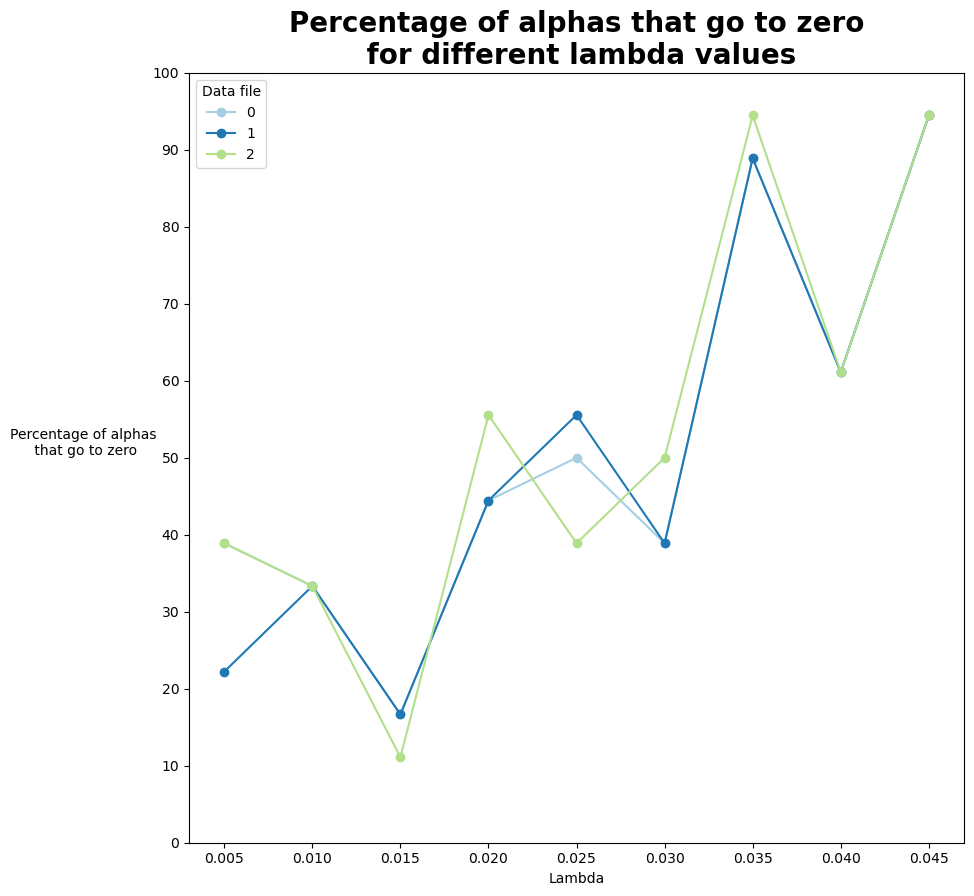

In [13]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
for df in percentages_df["df"].unique():
    ax.plot(
        percentages_df[percentages_df["df"] == df]["lambda"],
        percentages_df[percentages_df["df"] == df]["total"],
        marker="o",
        label=df
    )
ax.set_xlabel("Lambda")
ax.set_ylabel("Percentage of alphas\n that go to zero", rotation=0, labelpad=50)
ax.set_title(
    "Percentage of alphas that go to zero\n for different lambda values",
    fontweight="bold",
    size=20,
)
ax.set_yticks(np.arange(0, 101, 10))
ax.legend(title="Data file")
plt.savefig("./plots/alphas_total.png")

Dati molto sospetti zio pera... raccogline altri e vedi che succede. Se il pattern persiste cercare di capirne la causa

## Distribution of converged values

In [19]:
# Getting all the converged values
for file in data_files:
    final_values = pd.DataFrame(columns=["lambda", "alpha0", "alpha1", "alpha2"])
    df = pd.read_csv(file)
    lambda_range = df["lambda"].unique()
    for Lambda in lambda_range:
        df_lambda = df[df["lambda"] == Lambda].groupby("iteration").tail(1)
        final_values = pd.concat(
            [final_values, df_lambda[["lambda", "alpha0", "alpha1", "alpha2"]]],
            ignore_index=True,
        )

print(final_values)

/tmp/ipykernel_10528/2679538018.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_values = pd.concat(
/tmp/ipykernel_10528/2679538018.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_values = pd.concat(


    lambda  alpha0  alpha1  alpha2
0    0.005  0.5092  0.0000  0.3778
1    0.005  0.0000  0.5702  0.0000
2    0.005  0.9798  0.0000  0.0010
3    0.005  0.5269  0.7646  0.1273
4    0.005  0.4224  0.7048  0.0000
5    0.005  0.0000  0.0000  0.5945
6    0.010  0.9927  0.0000  0.1983
7    0.010  0.0000  0.6296  0.0000
8    0.010  0.2563  0.3669  0.3586
9    0.010  0.0000  0.8031  0.0000
10   0.010  0.2821  0.6349  0.0006
11   0.010  0.0000  0.2347  0.3549
12   0.015  0.8808  0.0001  0.0031
13   0.015  0.7084  0.0002  0.1927
14   0.015  0.9763  0.0000  0.0001
15   0.015  0.7384  0.0000  0.1862
16   0.015  0.1491  0.0453  0.1439
17   0.015  0.7749  0.1232  0.1084
18   0.020  0.3477  0.0000  0.3406
19   0.020  0.4733  0.1008  0.2613
20   0.020  0.0000  0.0000  0.0000
21   0.020  0.0000  0.0000  0.0000
22   0.020  0.0000  0.0000  0.3854
23   0.020  0.0000  0.0002  0.0005
24   0.025  0.0851  0.1146  0.4163
25   0.025  0.0000  0.0113  0.3964
26   0.025  0.0000  0.0000  0.0002
27   0.025  0.0000  

/tmp/ipykernel_10528/2679538018.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_values = pd.concat(


/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

<Axes: xlabel='alpha0'>

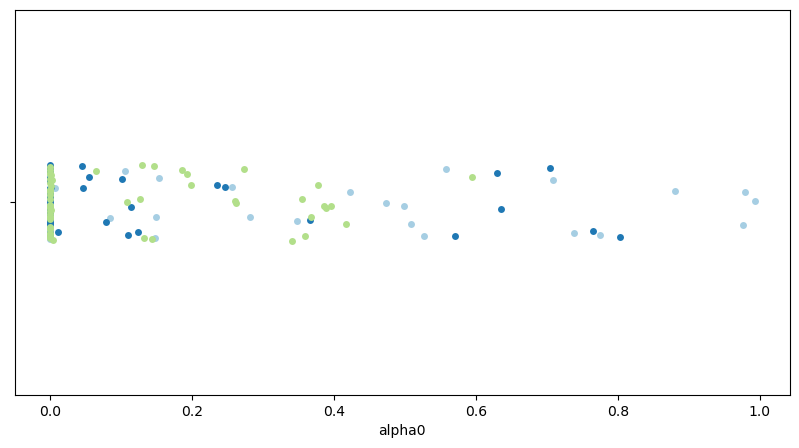

In [26]:
# Plotting converged values in a boxplot
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
sns.stripplot(data=final_values, x="alpha0", ax=ax)
sns.stripplot(data=final_values, x="alpha1", ax=ax)
sns.stripplot(data=final_values, x="alpha2", ax=ax)


In [69]:
print(final_values)

    lambda  alpha0  alpha1  alpha2
0    0.005  0.5092  0.0000  0.3778
1    0.005  0.0000  0.5702  0.0000
2    0.005  0.9798  0.0000  0.0010
3    0.005  0.5269  0.7646  0.1273
4    0.005  0.4224  0.7048  0.0000
5    0.005  0.0000  0.0000  0.5945
6    0.010  0.9927  0.0000  0.1983
7    0.010  0.0000  0.6296  0.0000
8    0.010  0.2563  0.3669  0.3586
9    0.010  0.0000  0.8031  0.0000
10   0.010  0.2821  0.6349  0.0006
11   0.010  0.0000  0.2347  0.3549
12   0.015  0.8808  0.0001  0.0031
13   0.015  0.7084  0.0002  0.1927
14   0.015  0.9763  0.0000  0.0001
15   0.015  0.7384  0.0000  0.1862
16   0.015  0.1491  0.0453  0.1439
17   0.015  0.7749  0.1232  0.1084
18   0.020  0.3477  0.0000  0.3406
19   0.020  0.4733  0.1008  0.2613
20   0.020  0.0000  0.0000  0.0000
21   0.020  0.0000  0.0000  0.0000
22   0.020  0.0000  0.0000  0.3854
23   0.020  0.0000  0.0002  0.0005
24   0.025  0.0851  0.1146  0.4163
25   0.025  0.0000  0.0113  0.3964
26   0.025  0.0000  0.0000  0.0002
27   0.025  0.0000  

     lambda variable   value
0     0.005   alpha0  0.5092
1     0.005   alpha0  0.0000
2     0.005   alpha0  0.9798
3     0.005   alpha0  0.5269
4     0.005   alpha0  0.4224
..      ...      ...     ...
157   0.045   alpha2  0.0010
158   0.045   alpha2  0.0000
159   0.045   alpha2  0.0000
160   0.045   alpha2  0.0000
161   0.045   alpha2  0.0000

[162 rows x 3 columns]


/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

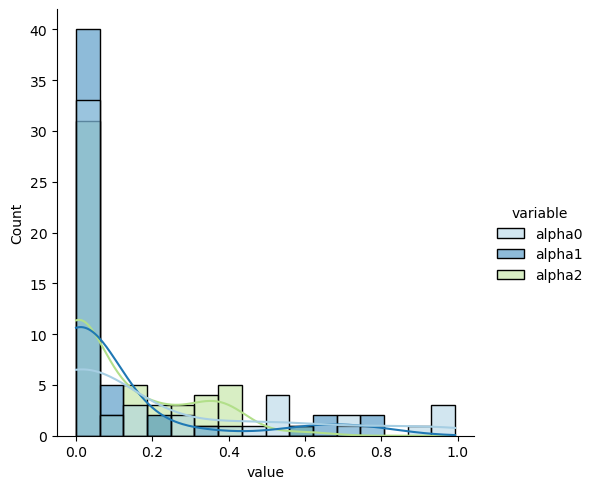

In [72]:
# Melt the DataFrame to have a single column for values and another for variable names
melted_values = final_values.melt(var_name="variable", value_name="value", id_vars="lambda")
print(melted_values)
# Create a displot with hue and custom palette
sns.displot(
    data=melted_values, x="value", hue="variable", palette=custom_colors, kde=True
)

plt.show()

/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pettepiero/local/envs/atml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

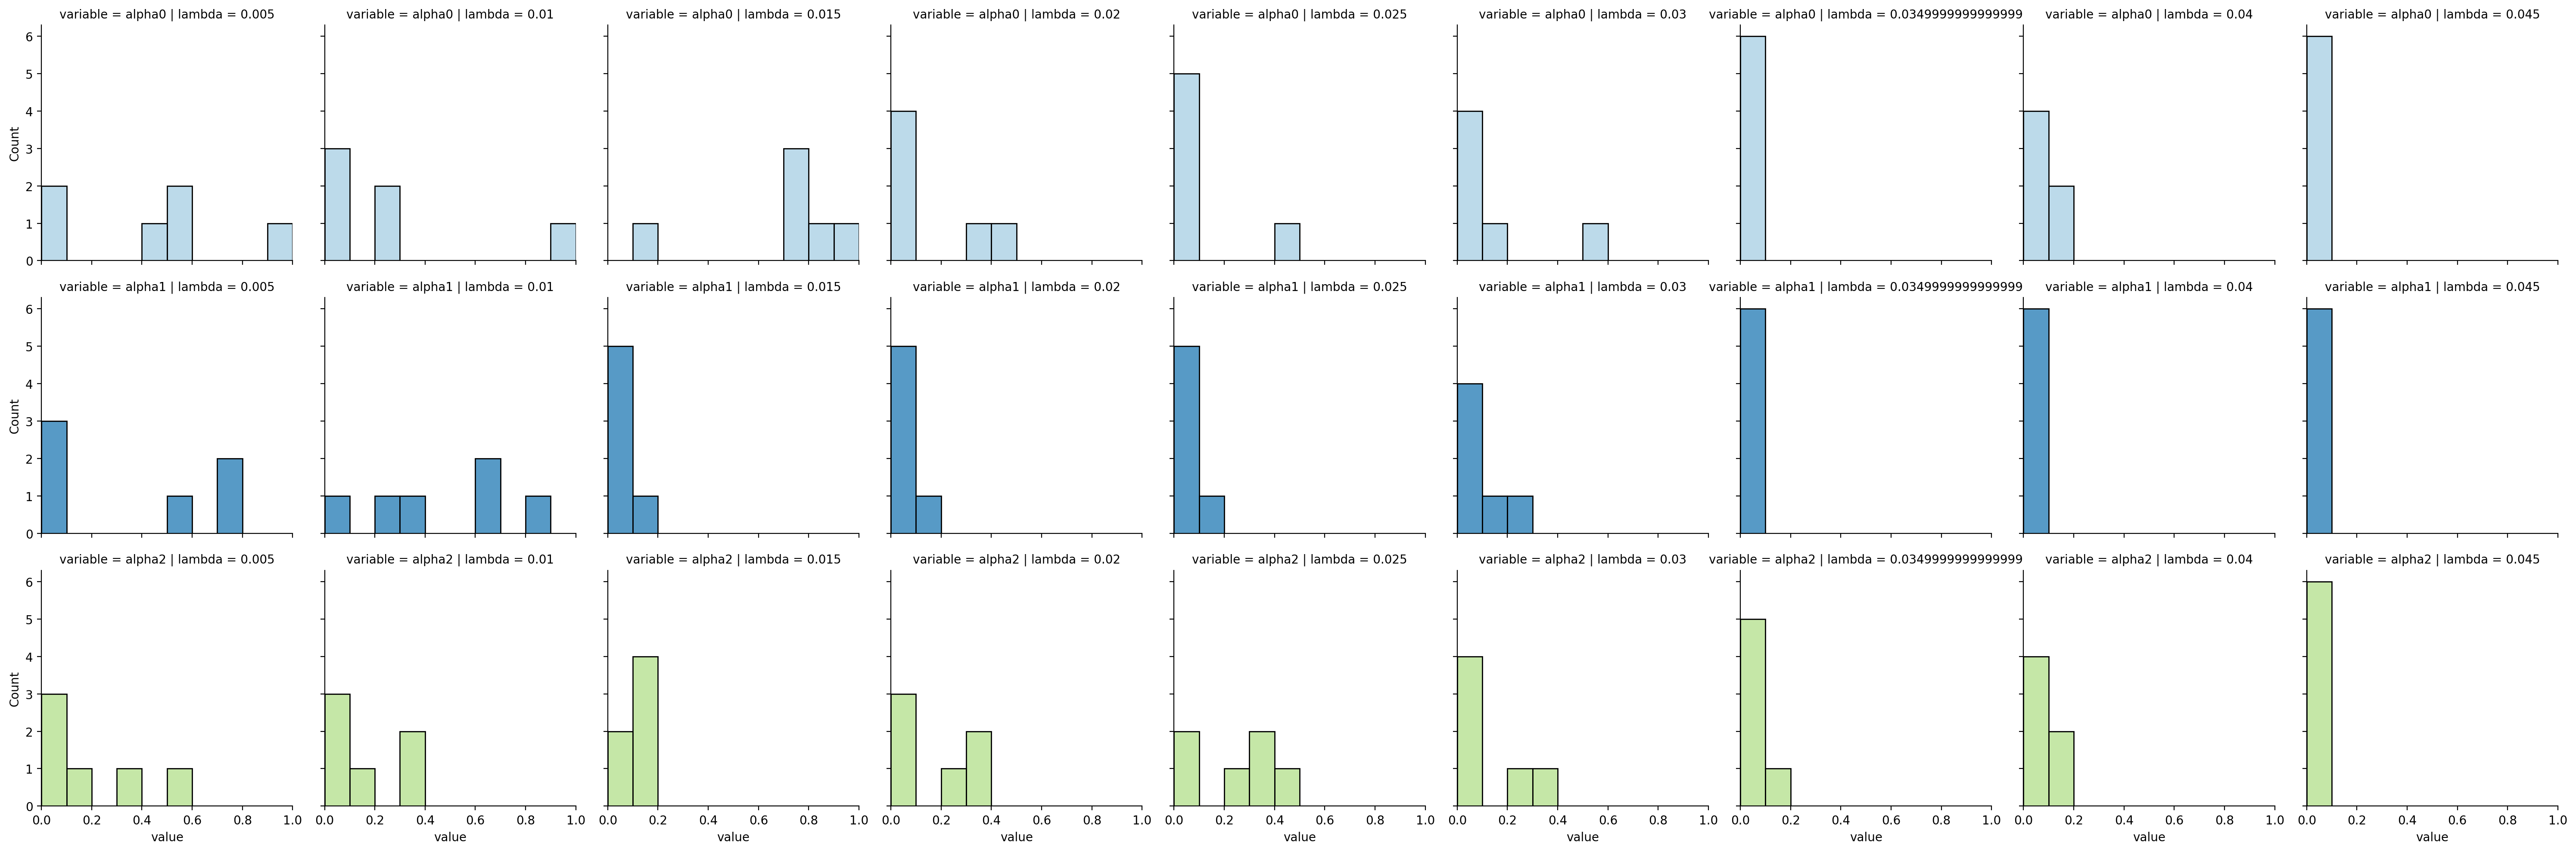

In [87]:
bin_edges = [i / 10 for i in range(11)]

g = sns.FacetGrid(
    melted_values, row="variable", col="lambda", hue="variable", palette=custom_colors
)
g.map(sns.histplot, "value", bins=bin_edges)
g.set(xlim=(0, 1))
g.fig.set_size_inches(30, 10)
g.fig.set_dpi(200)
g.fig.tight_layout()
plt.show()